In [1]:
# Import
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# Import data
data= pd.read_csv("data_stocks.csv")

In [3]:
data.head

<bound method NDFrame.head of              DATE      SP500  NASDAQ.AAL  NASDAQ.AAPL  NASDAQ.ADBE  \
0      1491226200  2363.6101     42.3300     143.6800     129.6300   
1      1491226260  2364.1001     42.3600     143.7000     130.3200   
2      1491226320  2362.6799     42.3100     143.6901     130.2250   
3      1491226380  2364.3101     42.3700     143.6400     130.0729   
4      1491226440  2364.8501     42.5378     143.6600     129.8800   
5      1491226500  2365.6201     42.5399     143.7800     130.0700   
6      1491226560  2365.2000     42.4700     143.8640     130.1800   
7      1491226620  2365.2900     42.4700     143.8100     130.1400   
8      1491226680  2364.3201     42.3900     143.8150     130.1000   
9      1491226740  2364.6399     42.3300     143.8000     130.2100   
10     1491226800  2364.5801     42.4000     143.8900     130.1400   
11     1491226860  2364.4800     42.2900     143.9700     130.3700   
12     1491226920  2365.2300     42.2900     143.9199     13

In [4]:
# Drop date variable
data = data.drop(['DATE'], 1)

In [5]:
# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]


In [6]:
# Make data a np.array
data = data.values


In [7]:
# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]


In [8]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)


In [9]:
# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]


In [10]:
# Number of stocks in training data
n_stocks = X_train.shape[1]


In [11]:
# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

In [12]:
# Session
net = tf.InteractiveSession()

In [13]:
# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])


In [14]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [15]:
# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))


In [17]:
# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))


In [18]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))


In [19]:
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))


In [20]:
# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)


In [21]:
# Init
net.run(tf.global_variables_initializer())

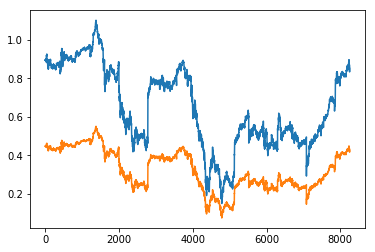

In [22]:
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()


In [23]:
# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

In [24]:

# Run
epochs = 10
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
#             plt.ion()
#             fig = plt.figure()
#             ax1 = fig.add_subplot(111)
#             line1, = ax1.plot(y_test)
#             line2= ax1.plot(pred)
#             plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
#             plt.show()
#             plt.pause(0.01)

MSE Train:  1.4686236
MSE Test:  4.1338005
MSE Train:  0.00059100246
MSE Test:  0.02437776
MSE Train:  0.0002507506
MSE Test:  0.01187264
MSE Train:  0.00014375606
MSE Test:  0.009867926
MSE Train:  0.00016781889
MSE Test:  0.0076377974
MSE Train:  0.00010559937
MSE Test:  0.0066846884
MSE Train:  0.00045649704
MSE Test:  0.006516764
MSE Train:  0.00012854679
MSE Test:  0.0056741056
MSE Train:  0.00015355203
MSE Test:  0.005412528
MSE Train:  0.00017882856
MSE Test:  0.005160371
MSE Train:  0.0001271371
MSE Test:  0.0043609315
MSE Train:  0.0001022827
MSE Test:  0.0041963793
MSE Train:  9.175149e-05
MSE Test:  0.0043840767
MSE Train:  7.728491e-05
MSE Test:  0.0044917837
MSE Train:  7.6608645e-05
MSE Test:  0.004013201
MSE Train:  0.00014554586
MSE Test:  0.0035823195
MSE Train:  7.128899e-05
MSE Test:  0.0042825295
MSE Train:  9.545717e-05
MSE Test:  0.0038095843
MSE Train:  0.00014452114
MSE Test:  0.0045461957
MSE Train:  9.566397e-05
MSE Test:  0.0037929479
MSE Train:  6.030148e-05